# Задача 2

Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

1) Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
2) Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
3) Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

* Бонус: опишите, насколько удобным для использования вам показался Orbit. Если есть опыт использования других прогнозных инструментов (Prophet, Darts и т.д.) – сравните Orbit с ними по тем признакам, которые вам кажутся наиболее важными.

Формат сдачи задания – merge request в GitLab с ноутбуком, где выполнены вычисления (формат .ipynb).

## Подгружаем библиотеки

In [1]:
import pandas as pd
import pandahouse
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
import arviz as az

from orbit.eda import eda_plot
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
from orbit.diagnostics.metrics import rmsse

from causalimpact import CausalImpact

2024-08-08 15:40:00.683507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 15:40:01.879861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240720',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
q = '''
with tab1 as (
    SELECT 
        date,
        count(user_id) new_users
    FROM
        (SELECT
            user_id,
            min(toDate(time)) date
        FROM simulator_20240720.feed_actions
        GROUP BY user_id)
    GROUP BY date),
tab2 as (
    SELECT
        toDate(time) date,
        uniq(user_id) users,
        countIf(action=='view') views,
        countIf(action=='like') likes,
        likes/views ctr
    FROM simulator_20240720.feed_actions fa
    GROUP BY date)
SELECT
    date,
    users,
    views,
    likes,
    ctr,
    new_users
FROM tab2
LEFT JOIN tab1
USING date
WHERE date < toDate(now())
'''

In [49]:
df = pandahouse.read_clickhouse(q, connection=connection)
df

,date,users,views,likes,ctr,new_users
0,2024-06-01,878,7603,1560,0.205182,878
1,2024-06-02,2238,62770,12816,0.204174,1819
2,2024-06-03,3105,105526,20958,0.198605,1849
3,2024-06-04,3721,118996,23800,0.200007,1652
4,2024-06-05,4617,174454,34504,0.197783,1809
...,...,...,...,...,...,...
63,2024-08-03,19554,833754,182190,0.218518,1304
64,2024-08-04,19572,744881,164565,0.220928,1338
65,2024-08-05,19768,710587,154251,0.217075,1580
66,2024-08-06,19363,719064,147718,0.205431,1084


In [5]:
df.drop(["date"], axis=1).corr()

,users,views,likes,ctr,new_users
users,1.000000,0.783030,0.780046,0.506419,0.081556
views,0.783030,1.000000,0.998635,0.501482,-0.051945
likes,0.780046,0.998635,1.000000,0.540470,-0.066458
ctr,0.506419,0.501482,0.540470,1.000000,-0.212576
new_users,0.081556,-0.051945,-0.066458,-0.212576,1.000000


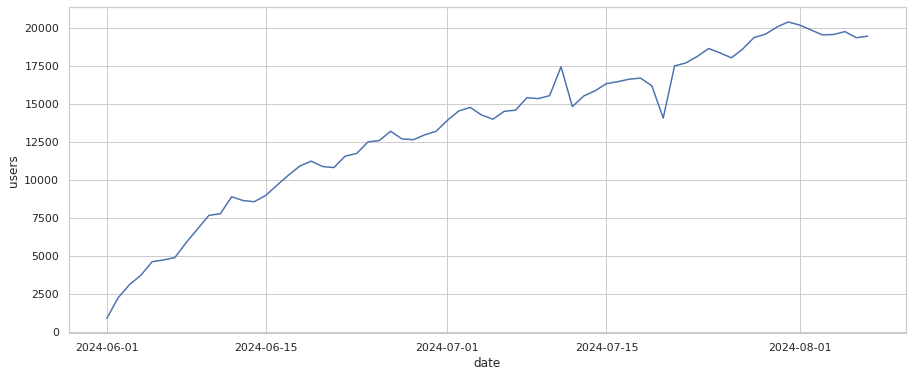

In [19]:
sns.set(rc={'figure.figsize':(15,6)}, style="whitegrid") # задаем шаблон для рисовалки
sns.lineplot(data=df, x='date', y='users')
plt.show()

## Задание 1

Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?

### Ответ

Я думаю, что оптимально взять метрику DAU так как она наиболее полно отражает рост приложения и нагрузку на сервера.

Временное расшерение возьмем дневное. Достаточно крупное для прогнозирования и с большим количеством данных.

Я думаю, что дополнительные регрессоры не нужны, так как скорее всего метрика DAU - корневая и влияет на все остальные метрики, но не наоборот.

## Задание 2 

Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.

In [7]:
dlt = DLT(response_col="users", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности 
          estimator="stan-mcmc", #алгоритм оценки
          num_warmup = 10000,
          num_sample = 2000
         ) #количество сэмплов бутстрапа для доверительного интервала

In [8]:
dlt.fit(df)

2024-08-08 15:40:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [9]:
future_df = dlt.make_future_df(periods=14)

In [10]:
predicted_df = dlt.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

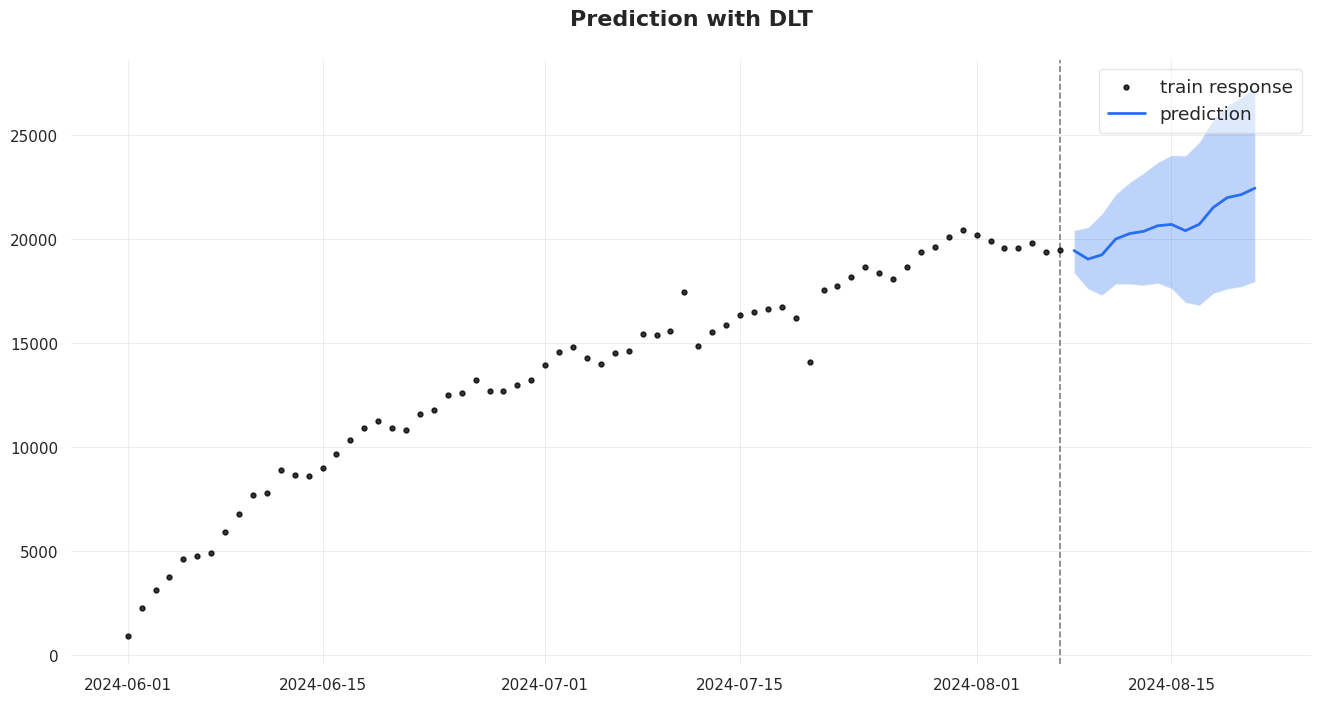

In [11]:
_ = plot_predicted_data(df, #изначальные данные
                        predicted_df, #датафрейм с предсказаниями
                        "date", #колонка со временем
                        'users', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

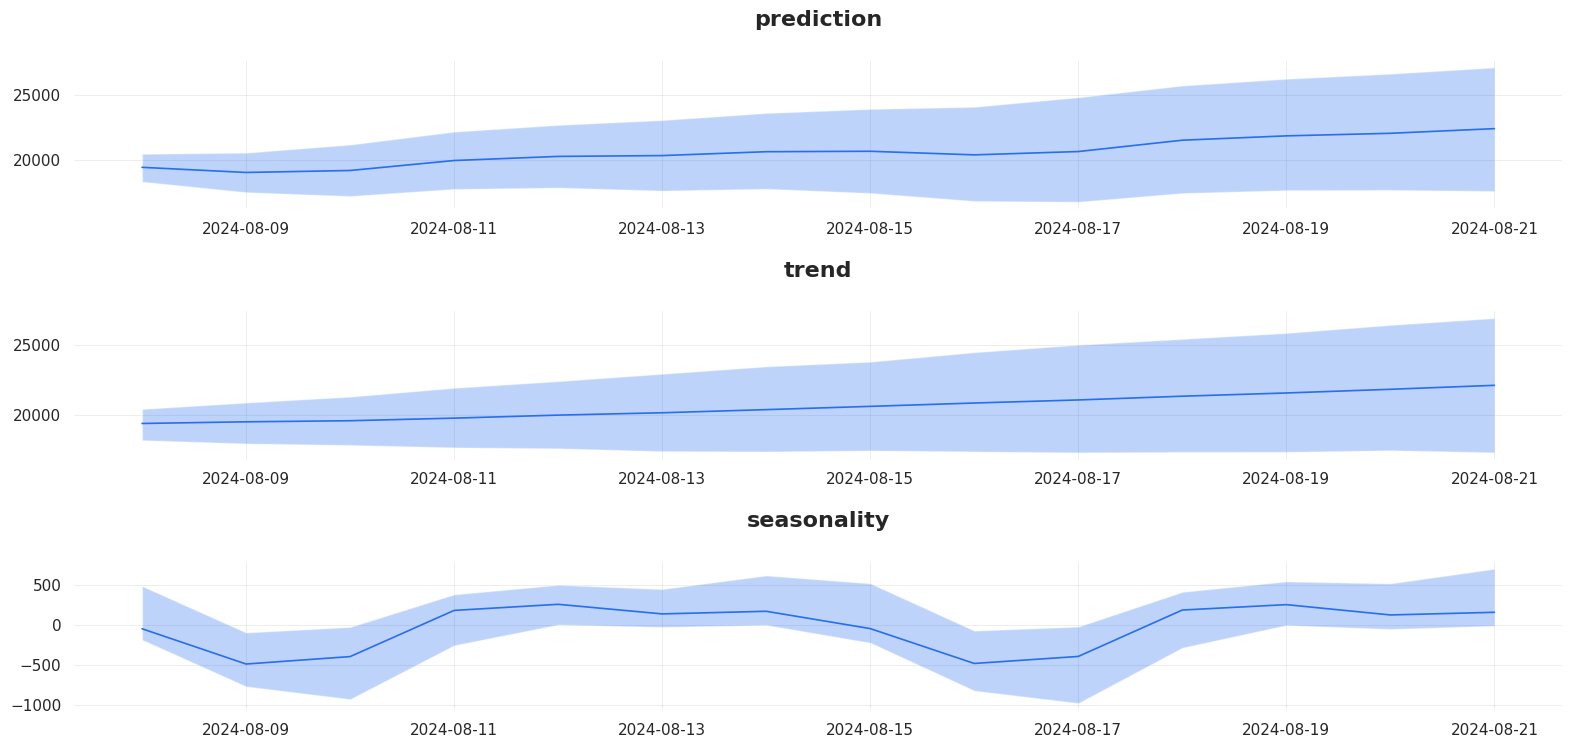

In [12]:
predicted_df = dlt.predict(df=future_df, 
                           decompose=True) #говорит, что нам нужна декомпозиция предсказания

_ = plot_predicted_components(predicted_df, 
                              "date", 
                              plot_components=['prediction', 'trend', 'seasonality'])

In [13]:
bt_exp = BackTester(
    model=dlt, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [14]:
bt_exp.fit_predict()
bt_exp.score()

2024-08-08 15:40:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 15:40:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,0.049918,False
1,wmape,0.046001,False
2,mape,0.050179,False
3,mse,688217.930006,False
4,mae,651.965491,False
5,rmsse,0.986374,False


Видны значительные ошибки в параметрах MSE и MAE, в таком виде моделька не заработает)

Скорее всего это происходит из-за наличия выбросов в наших данных, которые мы наблюдали на графике. Можно попробовать немного подчистить данные и сгладить.

In [15]:
df.describe()

,date,users,views,likes,ctr,new_users
count,68,68.000000,6.800000e+01,68.000000,68.000000,68.000000
mean,2024-07-04 12:00:00,13464.338235,5.218935e+05,109823.750000,0.208875,1880.529412
min,2024-06-01 00:00:00,878.000000,7.603000e+03,1560.000000,0.195531,878.000000
25%,2024-06-17 18:00:00,10688.500000,3.470865e+05,69160.500000,0.205070,1449.000000
50%,2024-07-04 12:00:00,14396.500000,4.906805e+05,103853.500000,0.208963,2006.500000
75%,2024-07-21 06:00:00,17558.250000,6.595792e+05,139911.000000,0.212183,2235.500000
max,2024-08-07 00:00:00,20400.000000,1.224097e+06,257747.000000,0.222221,3333.000000
std,NaN,5055.767428,2.661195e+05,57188.966226,0.006184,487.676626


In [47]:
df.query("date >= '2024-07-10' and date <= '2024-07-22'") # Вручную найдем даты, в которые случались аномалии
# Это даты 2024-07-11 и 2024-07-20
# заменим эти значения на среднее между днем до и днем после

,date,users,views,likes,ctr,new_users
39,2024-07-10,15549,487827,102839,0.210810,1957
40,2024-07-11,15189,635840,129325,0.203392,3333
41,2024-07-12,14829,672158,142206,0.211566,1069
42,2024-07-13,15526,885799,196843,0.222221,1959
43,2024-07-14,15867,1015529,220892,0.217514,2040
44,2024-07-15,16341,1166286,248806,0.213332,2293
45,2024-07-16,16469,1090531,230044,0.210947,1731
46,2024-07-17,16632,1085231,230093,0.212022,2025
47,2024-07-18,16705,1224097,257747,0.210561,1419
48,2024-07-19,16195,1106173,228125,0.206229,1272


In [53]:
clear_df = df.copy() # получаем "чистый дф" для анализа
clear_df.loc[40, 'users'] = (15549 + 14829) / 2
clear_df.loc[49, 'users'] = (16195 + 17510) / 2

<Axes: xlabel='date', ylabel='users'>

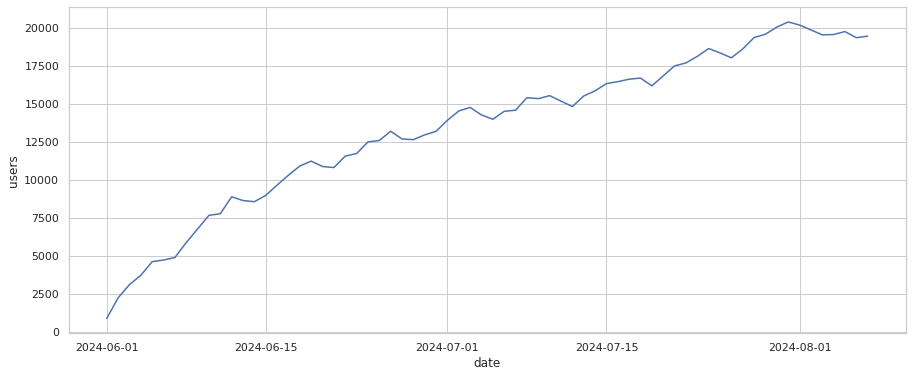

In [52]:
sns.lineplot(data=clear_df, x='date', y='users') 

In [62]:
clear_dlt = DLT(response_col="users", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности 
          estimator="stan-mcmc", #алгоритм оценки
          num_warmup = 10000,
          num_sample = 2000
         ) #количество сэмплов бутстрапа для доверительного интервала

In [63]:
clear_dlt.fit(clear_df)

2024-08-08 16:25:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [67]:
clear_future_df = clear_dlt.make_future_df(periods=14)

In [68]:
clear_predicted_df = clear_dlt.predict(df=clear_future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

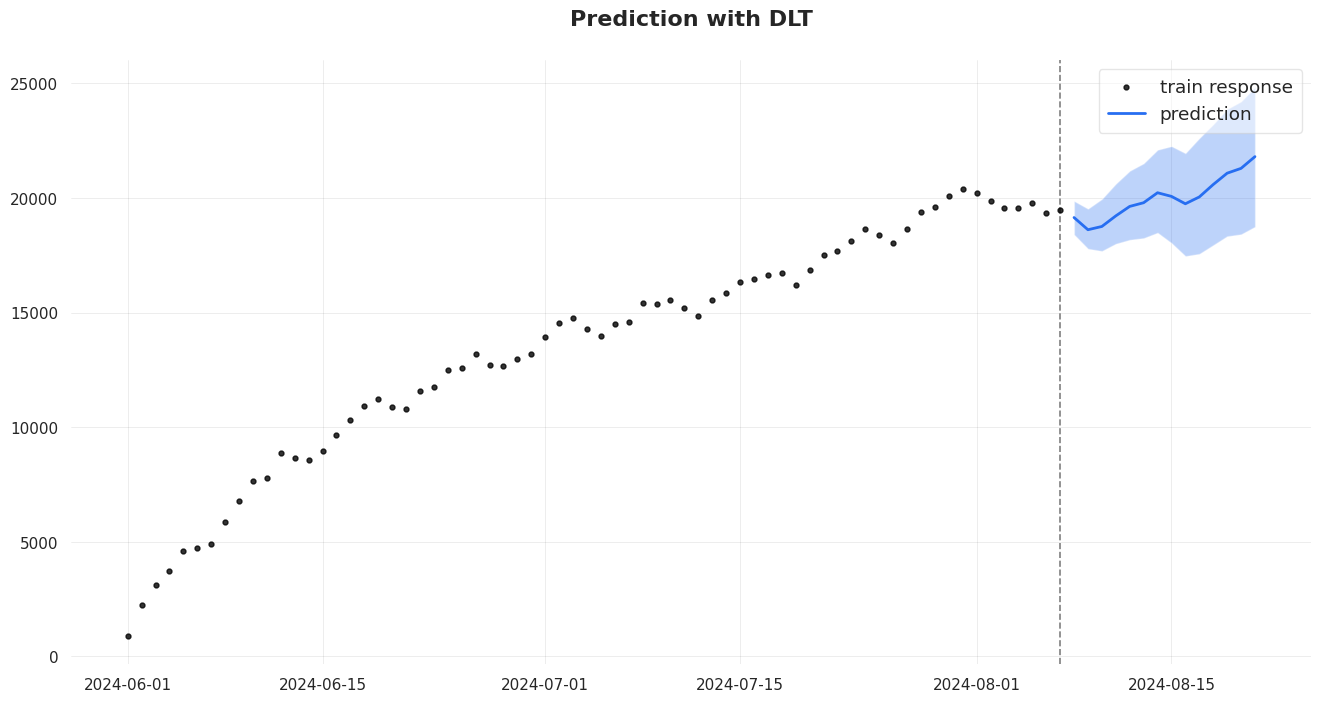

In [69]:
_ = plot_predicted_data(clear_df, #изначальные данные
                        clear_predicted_df, #датафрейм с предсказаниями
                        "date", #колонка со временем
                        'users', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

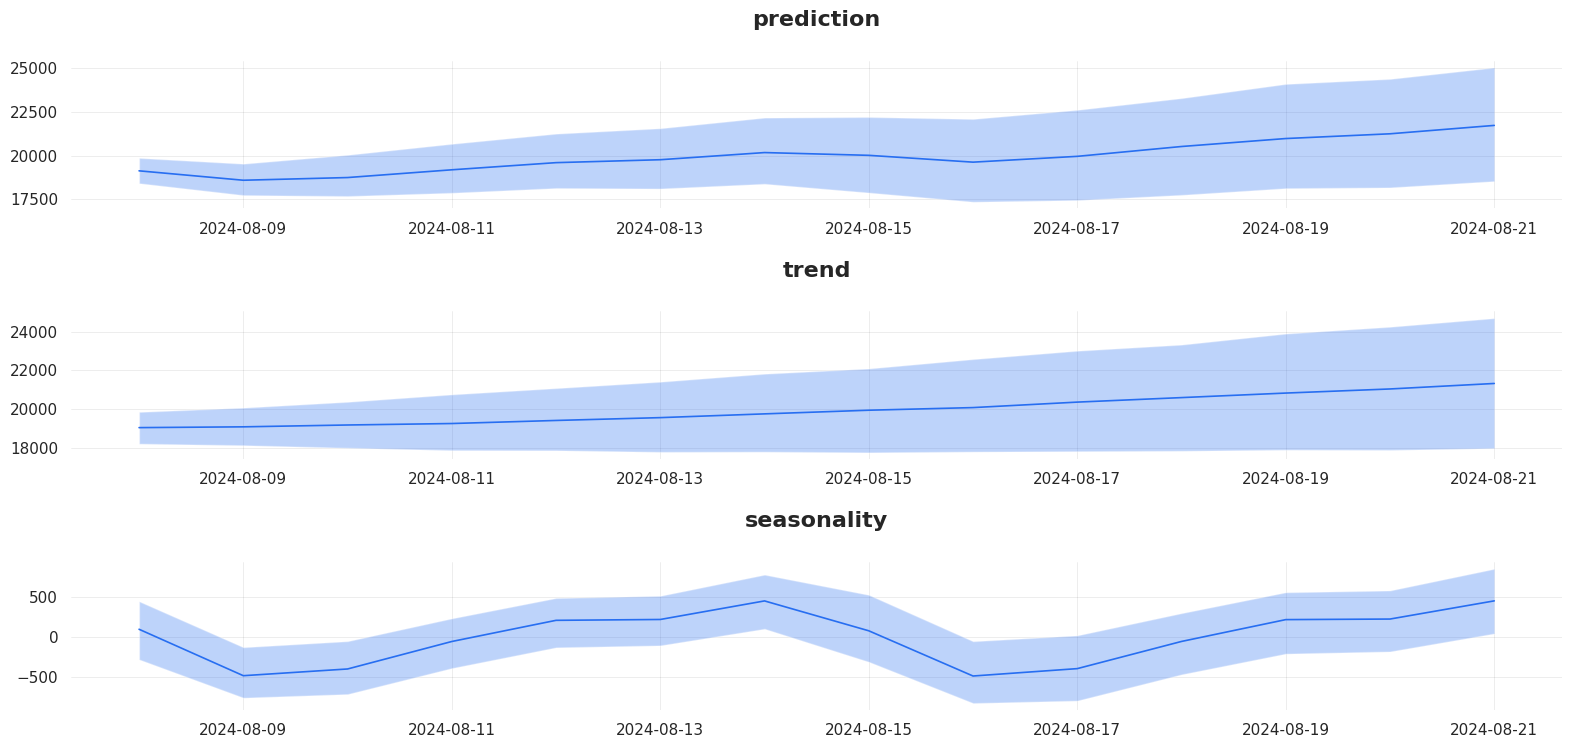

In [70]:
clear_predicted_df = clear_dlt.predict(df=clear_future_df, 
                           decompose=True) #говорит, что нам нужна декомпозиция предсказания

_ = plot_predicted_components(clear_predicted_df, 
                              "date", 
                              plot_components=['prediction', 'trend', 'seasonality'])

In [71]:
bt_exp = BackTester(
    model=clear_dlt, #наша моделька
    df=clear_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [72]:
bt_exp.fit_predict()
bt_exp.score()

2024-08-08 16:27:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:27:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:27:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:27:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:27:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:28:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:28:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-08-08 16:28:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,0.038235,False
1,wmape,0.031697,False
2,mape,0.038031,False
3,mse,353248.341041,False
4,mae,449.523347,False
5,rmsse,1.212681,False


In [73]:
params = clear_dlt.get_posterior_samples(permute=False) #достаём информацию о параметрах

params.keys() #их названия - можно залезть в оригинальный код на Stan, чтобы вычислить их значение

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [74]:
params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

(4, 500)

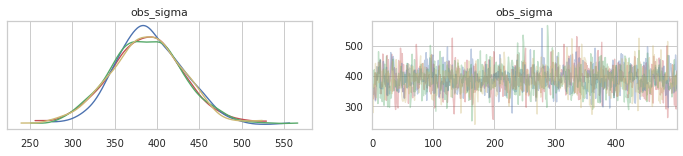

In [75]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")
plt.show()

In [76]:
train_df = clear_df.query("date < '2024-07-20'")
test_df = clear_df.query("date >= '2024-07-20'").astype({"views": "int64"})

In [77]:
dlt_reg = DLT(response_col="users", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности 
          estimator="stan-mcmc", #алгоритм оценки
          num_warmup = 2000,
          num_sample = 1000
          #regressor_col = ['views']
         ) #количество сэмплов бутстрапа для доверительного интервала

In [78]:
dlt_reg.fit(train_df)

2024-08-08 16:29:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [79]:
predicted_df_reg = dlt_reg.predict(df=test_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

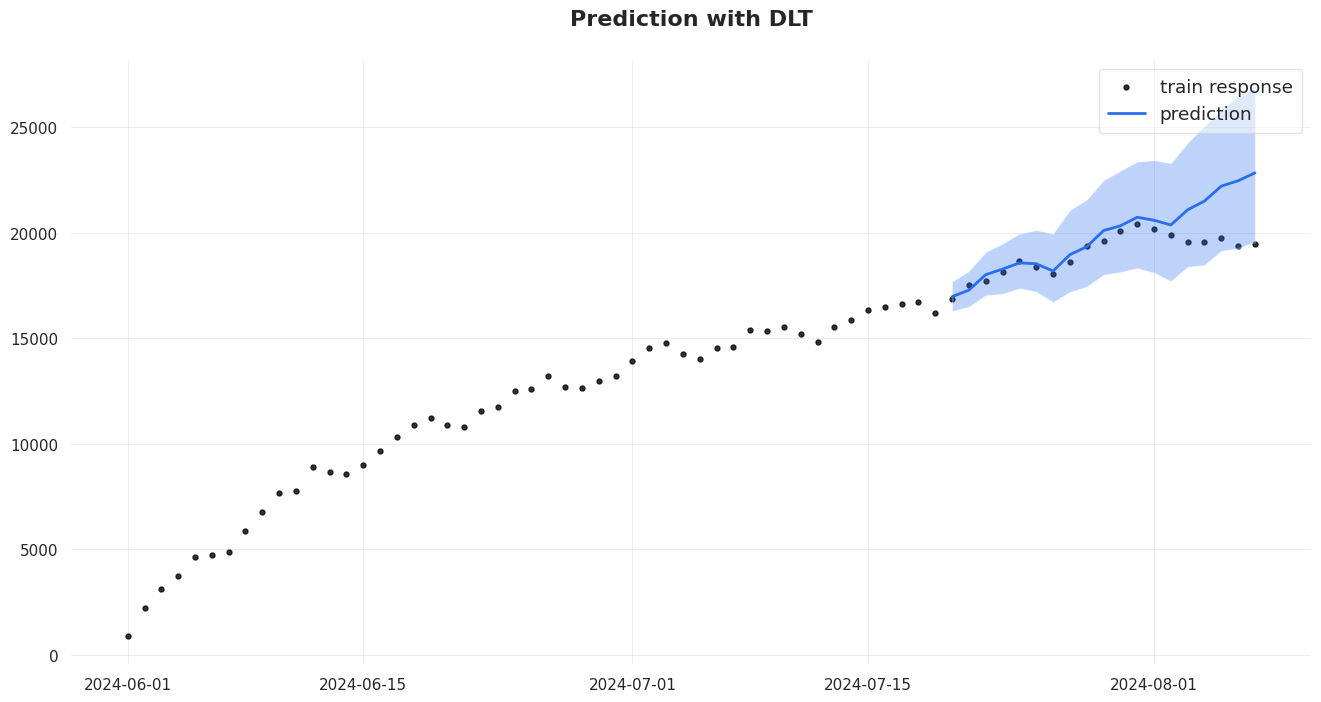

In [80]:
_ = plot_predicted_data(clear_df, predicted_df_reg, "date", 'users', title='Prediction with DLT')

Регрессоры в данном случае дают позитивного влияния.

но судя по нашим тестам, мы можем относительно точно предсказывать ДАУ на неделю вперед (в лучшем случае на 2). В дальнейшем идет сильное расхождение и я думаю, что для более долгосрочных предсказаний нам нужно собрать больше данных